# Cross-Domain RecSys EDA — Movies ↔ Music

Artifacts:
- `train.parquet`, `val.parquet`, `test.parquet`
- `maps/user_id_map.json`, `maps/item_id_map.json`

Columns per split:
`uid, iid, ts, ts_norm, rating, rating_norm, item_cat, split`

What we’ll do:
- sanity checks (sizes, disjointness, time ordering)
- cold-start vs train
- activity and long-tail
- ratings and monthly trends
- category coverage and “unknown” rate
- bridge users and heatmaps (Music → Movie) with cleaned categories


## Import & Settings

In [68]:
import json
import ast
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Catch-alls / format / studio noise you don’t want as “genres”
CATCHALL_MOVIE = {"All Titles", "General"}
CATCHALL_MUSIC = {"unknown", "Unknown"}

MOVIE_NOISE_RX = re.compile(
    r"(DTS|Blu-?ray|DVD|4K|UHD|VHS|Region|Box Set|Subtitled|Widescreen|"
    r"Sony|Warner|Universal|Paramount|Lionsgate|BBC|HBO|MGM|Disney|20th Century Fox|Anchor Bay|Fox)",
    re.I,
)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

plt.rcParams["figure.figsize"] = (7, 4)
pd.set_option("display.max_rows", 50)
pd.set_option("display.width", 140)

def to_dt(s):
    return pd.to_datetime(s, unit="s", errors="coerce")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


## Path

In [69]:
# Change to your preprocess --out path
ART = Path("../artifacts/movies_from_music")

DATA_DIR = ART / "data"
MAPS_DIR = ART / "maps"

# Heatmap & filtering knobs
MIN_USERS_PER_CAT = 50      # drop ultra-rare categories in heatmaps
TOPK_MUSIC_CATS   = 15
TOPK_MOVIE_CATS   = 15


## Load Splits

In [70]:
train = pd.read_parquet(DATA_DIR / "train.parquet")
val   = pd.read_parquet(DATA_DIR / "val.parquet")
test  = pd.read_parquet(DATA_DIR / "test.parquet")

for df, name in [(train, "train"), (val, "val"), (test, "test")]:
    df["phase"] = name

len(train), len(val), len(test)


(4328663, 319812, 507035)

## Load ID maps and recover domain names from iid

In [71]:
# item_id_map.json is { "<DOMAIN>::<ASIN>" : iid }
iid_map_series = pd.read_json(MAPS_DIR / "item_id_map.json", typ="series")
item_key_by_iid = dict(zip(iid_map_series.values.tolist(), iid_map_series.index.tolist()))

def iid_to_domain(iid: int) -> str:
    key = item_key_by_iid.get(int(iid), "")
    return key.split("::", 1)[0] if "::" in key else "Unknown"

for df in (train, val, test):
    df["domain"] = df["iid"].map(iid_to_domain)

sorted(pd.concat([train, val, test])["domain"].dropna().unique())


['CDs_and_Vinyl', 'Movies_and_TV']

##  Split sizes & basic density

In [72]:
def split_info(df, name):
    users = df["uid"].nunique()
    items = df["iid"].nunique()
    inter = len(df)
    dens = inter / max(1, users*items)
    return pd.Series({"rows": inter, "users": users, "items": items, "density": dens}, name=name)

pd.concat([split_info(train, "train"),
           split_info(val, "val"),
           split_info(test, "test")], axis=1)


,train,val,test
rows,4.328663e+06,319812.000000,507035.000000
users,5.070350e+05,319812.000000,507035.000000
items,4.432280e+05,57589.000000,74597.000000
density,1.926144e-05,0.000017,0.000013


## Disjointness and time-ordering sanity

In [73]:
# exact row signature
def sig(df):
    return df[["uid","iid","ts"]].astype(np.int64).astype(str).agg("|".join, axis=1)

over_tv = set(sig(train)).intersection(sig(val))
over_tt = set(sig(train)).intersection(sig(test))
over_vt = set(sig(val)).intersection(sig(test))
print("Row overlaps (train∩val, train∩test, val∩test):", len(over_tv), len(over_tt), len(over_vt))

# val time < test time per user (target domain users)
vt = val.merge(test, on="uid", suffixes=("_v","_t"))
print("% users with val_ts < test_ts:", (vt["ts_v"] < vt["ts_t"]).mean() if len(vt) else "N/A")


Row overlaps (train∩val, train∩test, val∩test): 30827 590 62856
% users with val_ts < test_ts: 0.5396326591872725


## User activity & item popularity (long tail)

In [74]:
train_users = set(train["uid"])
train_items = set(train["iid"])

def cold_start(df, name):
    users_unseen = (~df["uid"].isin(train_users)).mean()
    items_unseen = (~df["iid"].isin(train_items)).mean()
    return pd.Series({
        f"{name}_users_not_in_train_pct": users_unseen,
        f"{name}_items_not_in_train_pct": items_unseen
    })

pd.concat([cold_start(val, "val"), cold_start(test, "test")])


val_users_not_in_train_pct     0.000000
val_items_not_in_train_pct     0.022970
test_users_not_in_train_pct    0.000000
test_items_not_in_train_pct    0.032509
dtype: float64

## Rating distributions (by split)

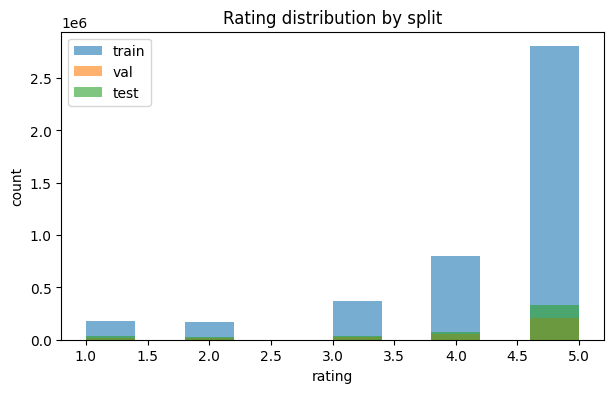

In [75]:
fig, ax = plt.subplots()
train["rating"].plot(kind="hist", bins=10, alpha=0.6, label="train")
val["rating"].plot(kind="hist", bins=10, alpha=0.6, label="val")
test["rating"].plot(kind="hist", bins=10, alpha=0.6, label="test")
ax.set_xlabel("rating"); ax.set_ylabel("count"); ax.set_title("Rating distribution by split")
ax.legend(); plt.show()


## Monthly interactions per domain

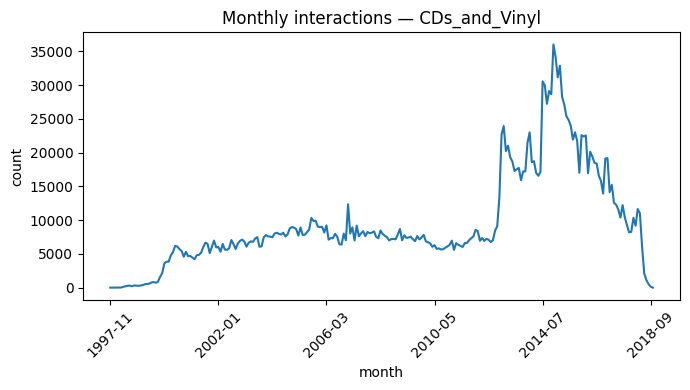

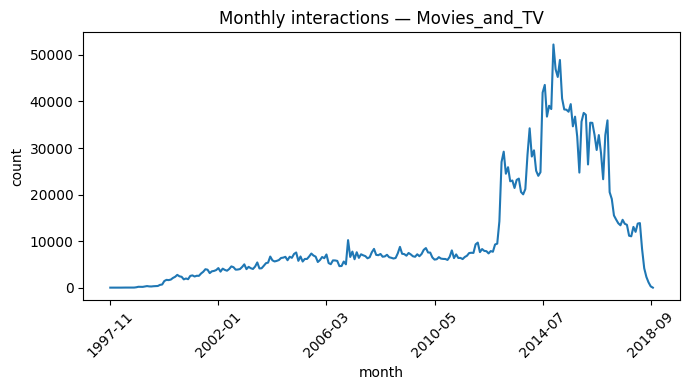

In [76]:
def monthly_counts(df, label):
    dt = to_dt(df["ts"]).dt.to_period("M")
    s = df.groupby(dt).size()
    s.index = s.index.astype(str)
    s.name = label
    return s

full = pd.concat([train, val, test], ignore_index=True)
for dom in sorted(full["domain"].unique()):
    series = monthly_counts(full[full["domain"]==dom], dom)
    ax = series.plot(kind="line")
    ax.set_title(f"Monthly interactions — {dom}")
    ax.set_xlabel("month"); ax.set_ylabel("count")
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()


## Category cleaners (turn raw paths into clean leaves)

In [77]:
import re, ast

GENERIC = {
    "CDs & Vinyl","Digital Music","Music","Albums","Songs",
    "Movies & TV","Movies","TV","Titles","Featured Categories",
    "Studio Specials","Home Entertainment","Unknown","unknown"
}

STUDIO_RX   = re.compile(r"(Sony|Warner|Universal|Paramount|Lionsgate|BBC|HBO|MGM|Disney|20th Century Fox|Anchor Bay|Fox)", re.I)
FORMAT_RX   = re.compile(r"\b(Blu-?ray|DVD|4K|UHD|VHS|Region|Box Set|Widescreen|Subtitled)\b", re.I)
ALL_TITLES_RX = re.compile(r"^(All(\s+[A-Za-z&]+)*\s+Titles?)$", re.I)   # e.g., "All Titles", "All Universal Studios Titles"
JUNK_CAT_RX   = re.compile(r"^(General|Special Interests?)$", re.I)

def _to_leaf(obj):
    if isinstance(obj, str) and obj.strip().startswith("["):
        try: obj = ast.literal_eval(obj)
        except Exception: pass
    if isinstance(obj, list) and obj and isinstance(obj[0], list):
        toks = [t for t in obj[0] if isinstance(t, str)]
        return toks[-1].strip() if toks else ""
    if isinstance(obj, list):
        return str(obj[-1]).strip() if obj else ""
    s = str(obj or "").strip()
    if ">" in s or "/" in s:
        parts = re.split(r">\s*|/\s*", s)
        return parts[-1].strip() if parts else s
    return s

def clean_music_cat(x):
    leaf = _to_leaf(x)
    leaf = re.sub(r"^(CDs\s*&\s*Vinyl|Digital\s*Music)\s*[:,/>\- ]*\s*", "", leaf, flags=re.I).strip()
    return "unknown" if (not leaf or leaf in GENERIC) else leaf

def clean_movie_cat(x):
    leaf = _to_leaf(x)
    leaf = re.sub(r"^(Movies\s*&\s*TV|Movies)\s*[:,/>\- ]*\s*", "", leaf, flags=re.I).strip()
    if (not leaf or
        leaf in GENERIC or
        STUDIO_RX.search(leaf) or
        FORMAT_RX.search(leaf) or
        ALL_TITLES_RX.match(leaf) or
        JUNK_CAT_RX.match(leaf)):
        return "unknown"
    return leaf


## Category coverage and top/lowest after cleaning

In [78]:
def cat_table(df, name, cleaner, topn=15):
    cat = df["item_cat"].map(cleaner).fillna("unknown").astype(str)
    vc = cat.value_counts()
    unk = (cat == "unknown").mean()
    out = pd.DataFrame({"category": vc.index, "count": vc.values})
    print(f"[{name}] unknown rate: {unk:.2%}")
    return out.head(topn), out.tail(min(topn, len(out)))

movie_dom = next((d for d in sorted(full["domain"].unique()) if "Movie" in d or "TV" in d), None)
music_dom = next((d for d in sorted(full["domain"].unique()) if "Vinyl" in d or "Music" in d), None)

if movie_dom and music_dom:
    top_mov, low_mov = cat_table(full[full["domain"]==movie_dom], movie_dom, clean_movie_cat, topn=15)
    top_mus, low_mus = cat_table(full[full["domain"]==music_dom], music_dom, clean_music_cat, topn=15)

    print("\nTop movie categories");  display(top_mov)
    print("\nLowest movie categories"); display(low_mov)
    print("\nTop music categories");  display(top_mus)
    print("\nLowest music categories"); display(low_mus)
else:
    print("Could not identify movie/music domains. Check domain names in the data.")


[Movies_and_TV] unknown rate: 46.64%
[CDs_and_Vinyl] unknown rate: 7.26%

Top movie categories


,category,count
0,unknown,1286547
1,Drama,217605
2,Comedy,205835
3,Action & Adventure,184308
4,Documentary,79572
5,Kids & Family,69933
6,Animation,69618
7,Horror,46957
8,Fantasy,44868
9,DTS,38265



Lowest movie categories


,category,count
447,"Mayer, John",1
448,Criterion Collection,1
449,"Taylor, James",1
450,While Supplies Last As always,1
451,The Judds,1
452,Spanish-Language,1
453,Barbarians,1
454,In Memoriam,1
455,Theater,1
456,"Monk, Thelonious",1



Top music categories


,category,count
0,unknown,173996
1,Pop,145266
2,Album-Oriented Rock (AOR),102743
3,Progressive Rock,61626
4,Today's Country,60556
5,Indie Rock,57484
6,Pop & Contemporary,57243
7,Adult Contemporary,49845
8,Adult Alternative,47282
9,Vocal Pop,46021



Lowest music categories


,category,count
486,Tanzania,8
487,Forms & Genres,8
488,Machine wash cold with like colors. Tumble dry...,8
489,</span></span></span>,8
490,Costa Rica,7
491,Vallenato,4
492,British Ska,4
493,"100% Cotton, 100% Custom",4
494,Eskimo & Inuit,3
495,El Salvador,3


## Bridge users (present in both domains)

In [79]:
if movie_dom and music_dom:
    users_movie = set(full.loc[full["domain"]==movie_dom, "uid"].unique())
    users_music = set(full.loc[full["domain"]==music_dom, "uid"].unique())
    bridge = users_movie & users_music
    print(f"Bridge users: {len(bridge):,} "
          f"({len(bridge)/max(1,len(users_movie|users_music)):.2%} of all users)")
else:
    bridge = set()


Bridge users: 507,035 (100.00% of all users)


## Bridge user scatter (activity per domain)

Domain value counts:
domain
Movies_and_TV    2758380
CDs_and_Vinyl    2397130
Name: count, dtype: int64 

Chosen domains: Movies_and_TV (movie) | CDs_and_Vinyl (music)

Users — movie=507,035 | music=507,035 | bridge=507,035 (100.00% of union)

Quadrant shares at k = 5
                        Users@k Interactions@k
warm-warm                 0.086          0.394
movie-warm | music-cold   0.165          0.232
movie-cold | music-warm   0.110          0.155
cold-cold                 0.639          0.219

Spearman ρ (activity correlation): 0.235


/tmp/ipykernel_2792584/626040686.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(tbl.applymap(lambda v: f"{v:.3f}"))
/tmp/ipykernel_2792584/626040686.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


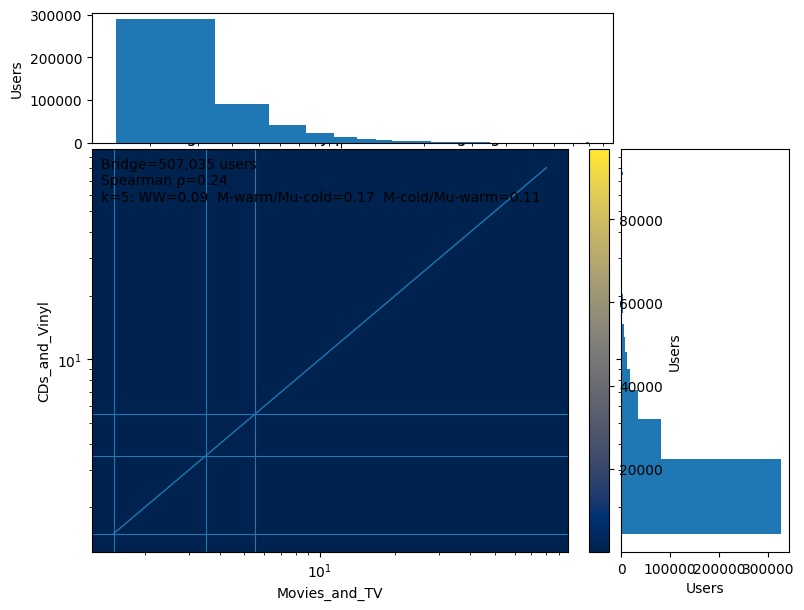

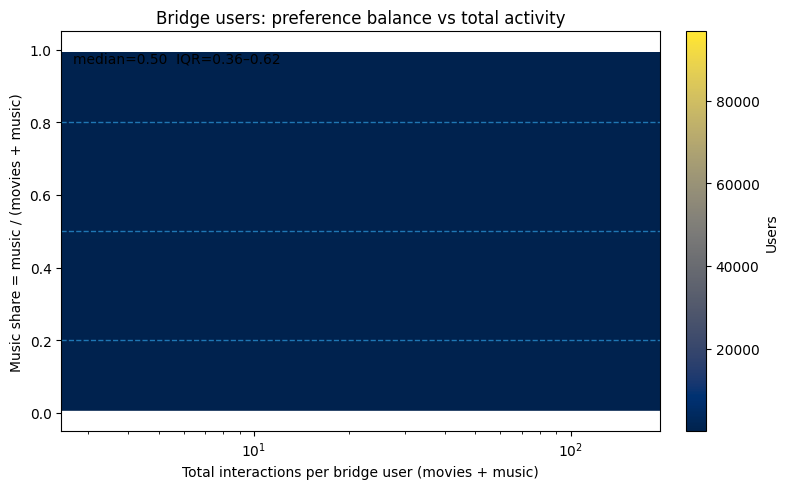

In [95]:
# ==== Bridge diagnostics + improved plots ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# put this near the top with the other params
CMAP = "cividis"   # good, colorblind-friendly. Alternatives: "plasma", "magma", "Blues", "turbo"

# ---------- params ----------
K = 5                  # warm/cold cut for the summary table
CUTS = [1, 3, 5]       # cut lines drawn on the joint plot
USE_HEXBIN = True      # density over scatter
GRIDSIZE = 60          # hexbin grid
EPS = 0.5              # avoids log(0)
CLIP_PCT = 99.5        # cap extremes to keep the dense region readable

# ---------- sanity: domains & bridge ----------
assert 'full' in globals(), "full not defined"
assert 'movie_dom' in globals() and 'music_dom' in globals(), "movie_dom/music_dom not defined"

print("Domain value counts:")
print(full['domain'].astype(str).value_counts().head(20), "\n")
print("Chosen domains:", movie_dom, "(movie) |", music_dom, "(music)")

users_movie = set(full.loc[full["domain"]==movie_dom, "uid"].astype(str).unique())
users_music = set(full.loc[full["domain"]==music_dom, "uid"].astype(str).unique())
bridge = users_movie & users_music
union  = users_movie | users_music
print(f"\nUsers — movie={len(users_movie):,} | music={len(users_music):,} | bridge={len(bridge):,} "
      f"({len(bridge)/max(1,len(union)):.2%} of union)")

if not bridge:
    raise SystemExit("No bridge users. Check domain labels or how music/movie frames were built.")

# ---------- per-user activity in each domain (bridge only) ----------
m_df = full[(full["domain"]==movie_dom) & (full["uid"].astype(str).isin(bridge))]
s_df = full[(full["domain"]==music_dom) & (full["uid"].astype(str).isin(bridge))]
m_u = m_df.groupby("uid").size()
s_u = s_df.groupby("uid").size()
df = pd.DataFrame({"movies": m_u, "music": s_u}).fillna(0).astype(float)

# ---------- quadrant shares (users + interactions) at K ----------
def quadrant_shares(df_counts, k):
    xv = df_counts["movies"].to_numpy()
    yv = df_counts["music"].to_numpy()
    a = (xv >= k) & (yv >= k)   # warm-warm
    b = (xv >= k) & (yv <  k)   # movie-warm | music-cold
    c = (xv <  k) & (yv >= k)   # movie-cold | music-warm
    d = (xv <  k) & (yv <  k)   # cold-cold
    n = len(xv)
    users = {
        "warm-warm": a.mean(),
        "movie-warm | music-cold": b.mean(),
        "movie-cold | music-warm": c.mean(),
        "cold-cold": d.mean(),
    }
    tot_inter = xv.sum() + yv.sum()
    inter = {
        "warm-warm": (xv[a].sum() + yv[a].sum())/tot_inter if tot_inter else np.nan,
        "movie-warm | music-cold": (xv[b].sum() + yv[b].sum())/tot_inter if tot_inter else np.nan,
        "movie-cold | music-warm": (xv[c].sum() + yv[c].sum())/tot_inter if tot_inter else np.nan,
        "cold-cold": (xv[d].sum() + yv[d].sum())/tot_inter if tot_inter else np.nan,
    }
    return users, inter

users_k, inter_k = quadrant_shares(df, K)
tbl = pd.DataFrame({"Users@k": users_k, "Interactions@k": inter_k})
print("\nQuadrant shares at k =", K)
print(tbl.applymap(lambda v: f"{v:.3f}"))

# ---------- Spearman correlation ----------
rho = df["movies"].corr(df["music"], method="spearman")
print(f"\nSpearman ρ (activity correlation): {rho:.3f}")

# ---------- JOINT plot (log–log) with marginals ----------
# prep data (offset + clip)
x = (df["movies"] + EPS).to_numpy()
y = (df["music"]  + EPS).to_numpy()
x_cap = np.percentile(x, CLIP_PCT); y_cap = np.percentile(y, CLIP_PCT)
x = np.minimum(x, x_cap); y = np.minimum(y, y_cap)

fig = plt.figure(figsize=(9, 7))
gs = GridSpec(4, 4, figure=fig, hspace=0.05, wspace=0.05)
ax_main  = fig.add_subplot(gs[1:, :3])
ax_top   = fig.add_subplot(gs[0,  :3], sharex=ax_main)
ax_right = fig.add_subplot(gs[1:,  3], sharey=ax_main)

# main density/scatter
if USE_HEXBIN:
    hb = ax_main.hexbin(x, y, gridsize=GRIDSIZE, mincnt=1, cmap=CMAP)
    cb = fig.colorbar(hb, ax=ax_main, fraction=0.046, pad=0.04)
    cb.set_label("Users")
else:
    ax_main.scatter(x, y, s=6, alpha=0.6)

ax_main.set_xscale("log"); ax_main.set_yscale("log")
ax_main.set_xlabel(movie_dom); ax_main.set_ylabel(music_dom)
ax_main.set_title("Bridge users: activity per domain (log–log)")

# y = x line
lo = min(x.min(), y.min()); hi = max(x.max(), y.max())
ax_main.plot([lo, hi], [lo, hi], linewidth=1)

# warm/cold cut lines
for k in CUTS:
    ax_main.axvline(k + EPS, linewidth=0.8)
    ax_main.axhline(k + EPS, linewidth=0.8)

# text summary
txt = (f"Bridge={len(df):,} users\n"
       f"Spearman ρ={rho:.2f}\n"
       f"k={K}: WW={users_k['warm-warm']:.2f}  "
       f"M-warm/Mu-cold={users_k['movie-warm | music-cold']:.2f}  "
       f"M-cold/Mu-warm={users_k['movie-cold | music-warm']:.2f}")
ax_main.text(0.02, 0.98, txt, transform=ax_main.transAxes, va="top")

# marginals
ax_top.hist(x, bins=40)
ax_top.set_xscale("log"); ax_top.tick_params(axis='x', labelbottom=False); ax_top.set_ylabel("Users")
ax_right.hist(y, bins=40, orientation="horizontal")
ax_right.set_yscale("log"); ax_right.tick_params(axis='y', labelleft=False); ax_right.set_xlabel("Users")

plt.tight_layout()
plt.show()

# ---------- RATIO–TOTAL plot ----------
tot   = x + y
ratio = y / np.maximum(1e-12, tot)

fig, ax = plt.subplots(figsize=(8, 5))
if USE_HEXBIN:
    # hb = ax.hexbin(tot, ratio, gridsize=GRIDSIZE, extent=(tot.min(), tot.max(), 0, 1), mincnt=1)
    hb = ax.hexbin(tot, ratio, gridsize=GRIDSIZE, extent=(tot.min(), tot.max(), 0, 1),
               mincnt=1, cmap=CMAP)
    cb = fig.colorbar(hb, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label("Users")
else:
    ax.scatter(tot, ratio, s=6, alpha=0.6)

ax.set_xscale("log")
ax.set_xlabel("Total interactions per bridge user (movies + music)")
ax.set_ylabel("Music share = music / (movies + music)")
ax.set_title("Bridge users: preference balance vs total activity")

# guide lines
for yline in [0.2, 0.5, 0.8]:
    ax.axhline(yline, linewidth=1, linestyle="--")

# annotate distribution
med = float(np.median(ratio))
q1  = float(np.quantile(ratio, 0.25))
q3  = float(np.quantile(ratio, 0.75))
ax.text(0.02, 0.95, f"median={med:.2f}  IQR={q1:.2f}–{q3:.2f}",
        transform=ax.transAxes, va="top")

plt.tight_layout()
plt.show()


## Heatmaps (Music → Movie) with cleaned categories

In [81]:
def user_cat_matrix(df, domain_name, min_users=50, binary=True, cleaner=None):
    cat = df["item_cat"]
    if cleaner:
        cat = cat.map(cleaner)
    cat = cat.fillna("unknown").astype(str)
    dfg = (df.assign(_cat=cat)
             .groupby(["uid","_cat"]).size()
             .unstack(fill_value=0))
    if binary:
        dfg = (dfg > 0).astype(int)
    keep = dfg.sum(axis=0)
    # drop 'unknown' and very rare
    dfg = dfg.loc[:, (keep >= min_users) & (dfg.columns != "unknown")]
    return dfg.rename_axis(index="uid", columns=f"{domain_name}_cat")

def select_top_cols(A, top_k):
    if top_k is None or A.shape[1] <= top_k:
        return A
    order = A.sum(axis=0).sort_values(ascending=False).index[:top_k]
    return A.loc[:, order]

def cross_heatmap(df_music, df_movie, normalize="row", min_users=50,
                  topk_music=15, topk_movie=15, title=None):
    M = user_cat_matrix(df_music, "music",  min_users=min_users, binary=True, cleaner=clean_music_cat)
    V = user_cat_matrix(df_movie, "movie",  min_users=min_users, binary=True, cleaner=clean_movie_cat)
    common = M.index.intersection(V.index)
    if len(common)==0:
        print("No bridge users after filtering."); return None, None
    M, V = M.loc[common], V.loc[common]
    M, V = select_top_cols(M, topk_music), select_top_cols(V, topk_movie)

    C = M.T.dot(V)  # raw counts of bridge users who touched both
    Cn = C.astype(float).copy()
    eps = 1e-12
    if normalize == "row":
        Cn = Cn.div(Cn.sum(axis=1).replace(0, np.nan), axis=0)                  # P(movie | music)
    elif normalize == "col":
        Cn = Cn.div(Cn.sum(axis=0).replace(0, np.nan), axis=1)
    elif normalize in {"lift","pmi"}:
        N = float(len(common))
        Pi = (M.sum(axis=0) / N).reindex(C.index).values.reshape(-1,1)
        Pj = (V.sum(axis=0) / N).reindex(C.columns).values.reshape(1,-1)
        lift = (C / N).values / (Pi * Pj + eps)
        Cn = pd.DataFrame(lift if normalize=="lift" else np.log2(lift + eps),
                          index=C.index, columns=C.columns)

    fig, ax = plt.subplots(figsize=(max(6, 0.45*Cn.shape[1]+2), max(5, 0.40*Cn.shape[0]+2)))
    im = ax.imshow(Cn.values, aspect="auto")
    ax.set_xticks(np.arange(Cn.shape[1])); ax.set_yticks(np.arange(Cn.shape[0]))
    ax.set_xticklabels(Cn.columns, rotation=45, ha="right", fontsize=8)
    ax.set_yticklabels(Cn.index, fontsize=8)
    ax.set_xlabel("Movie categories"); ax.set_ylabel("Music categories")
    if title: ax.set_title(title)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()
    return C, Cn


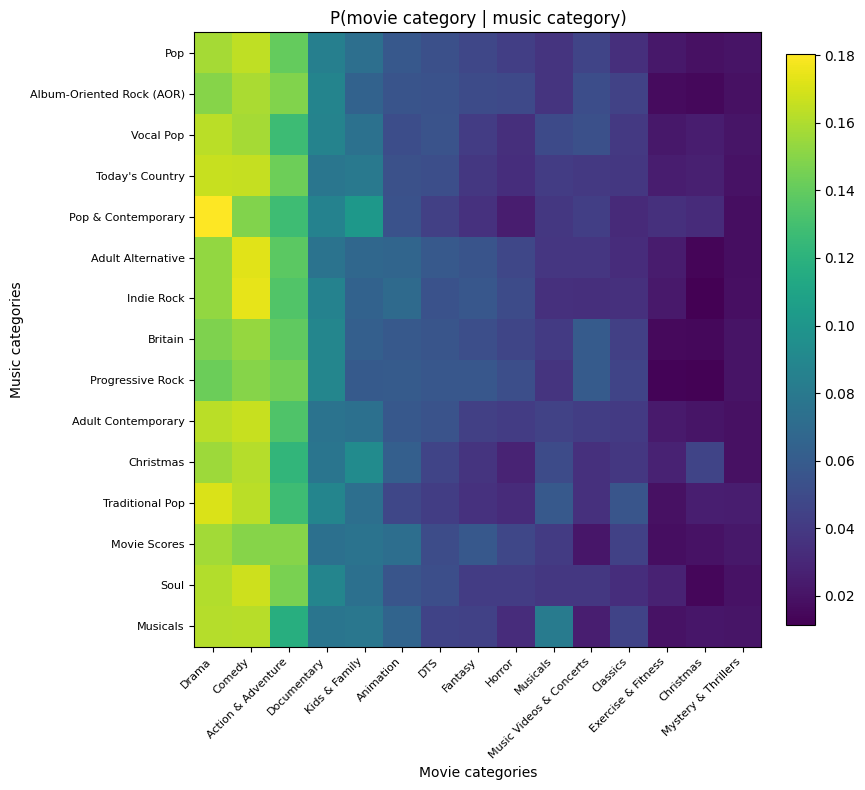

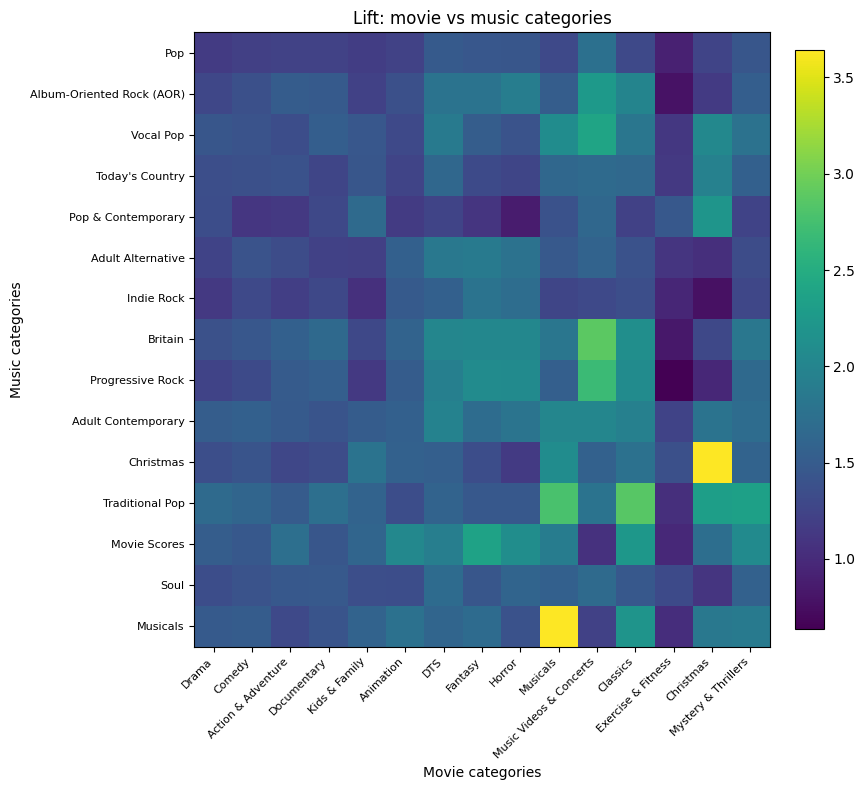

In [82]:
# Build per-domain frames across all splits
if movie_dom and music_dom:
    movie_df = full[full["domain"]==movie_dom]
    music_df = full[full["domain"]==music_dom]

    # P(movie | music)
    C_counts_row, C_row = cross_heatmap(
        music_df, movie_df, normalize="row",
        min_users=MIN_USERS_PER_CAT,
        topk_music=TOPK_MUSIC_CATS,
        topk_movie=TOPK_MOVIE_CATS,
        title="P(movie category | music category)"
    )

    # Lift (highlights over/under associations)
    _, C_lift = cross_heatmap(
        music_df, movie_df, normalize="lift",
        min_users=MIN_USERS_PER_CAT,
        topk_music=TOPK_MUSIC_CATS,
        topk_movie=TOPK_MOVIE_CATS,
        title="Lift: movie vs music categories"
    )
else:
    print("Need both Music and Movie domains present.")


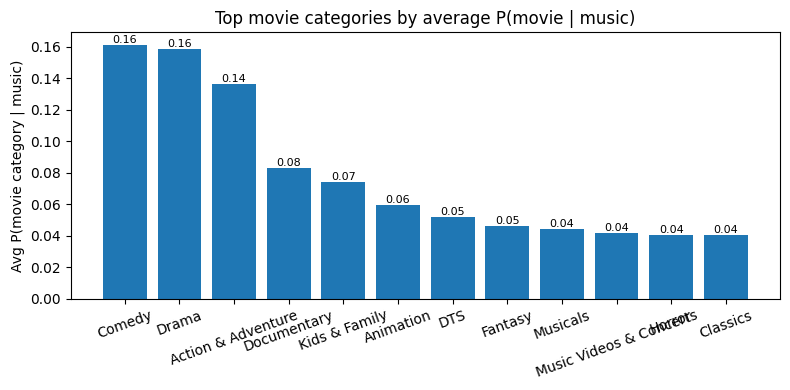

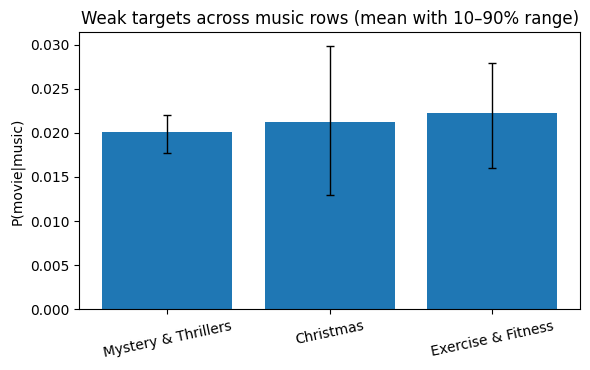

Weak targets (auto):
                       mean     p90
movie_cat                          
Mystery & Thrillers  0.0201  0.0220
Christmas            0.0212  0.0299
Exercise & Fitness   0.0222  0.0279


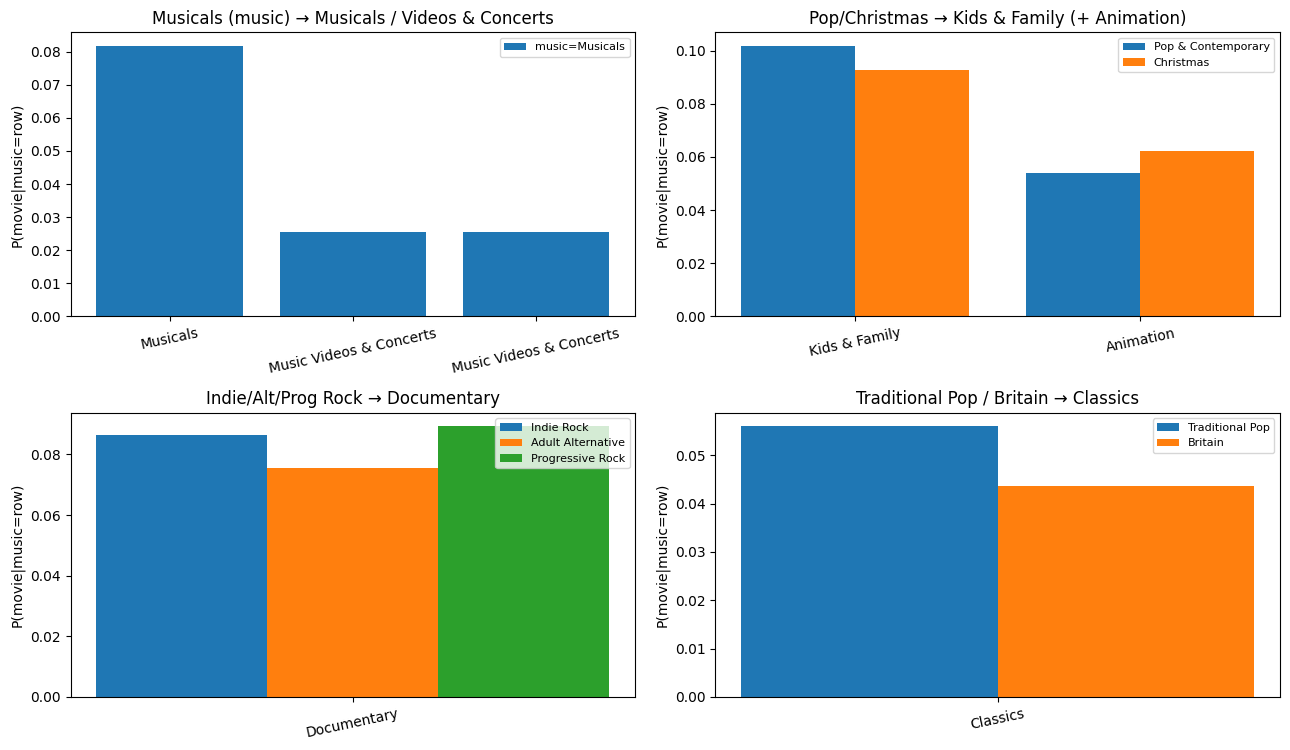

In [89]:
# === A + F as single plots; B–E combined as subplots (no base needed) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, math

# 0) get normalized heatmap and clean catalog buckets if they slipped in
if "C_row" not in globals():
    raise ValueError("C_row not found. Re-run cross_heatmap(..., normalize='row') first.")
P = C_row.copy()

drop_cols = [c for c in P.columns if re.search(r"\bAll\b.*\bTitles?\b", c, re.I)]
if drop_cols:
    P = P.drop(columns=drop_cols)
    P = P.div(P.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)

# helper: fuzzy pick a movie column name
def pick_col(name, cols):
    nl = name.lower()
    for c in cols:
        cl = c.lower()
        if cl == nl or cl.startswith(nl) or nl in cl:
            return c
    return None

# ---------------- Panel A: top movie categories by avg P(movie|music) ----------------
def plot_panel_A(P, topN=12):
    col_mean = P.mean(axis=0).sort_values(ascending=False).head(topN)
    plt.figure(figsize=(8, 4))
    plt.bar(col_mean.index, col_mean.values)
    for i, v in enumerate(col_mean.values):
        plt.text(i, v, f"{v:.2f}", ha="center", va="bottom", fontsize=8)
    plt.xticks(rotation=20)
    plt.ylabel("Avg P(movie category | music)")
    plt.title("Top movie categories by average P(movie | music)")
    plt.tight_layout()
    plt.show()
    return col_mean

# ---------------- Panel F: weak targets (low mean & low 90th percentile) -------------
def plot_panel_F(P, mean_thresh=0.03, p90_thresh=0.06, fallback_k=6):
    col_mean = P.mean(axis=0)
    col_p10  = P.quantile(0.10, axis=0)
    col_p90  = P.quantile(0.90, axis=0)
    weak_mask = (col_mean <= mean_thresh) & (col_p90 <= p90_thresh)
    weak_cols = col_mean[weak_mask].sort_values(ascending=True).index.tolist()
    if not weak_cols:
        # fallback: columns with lowest 90th percentile
        weak_cols = col_p90.sort_values(ascending=True).head(fallback_k).index.tolist()
    mean_vals = col_mean[weak_cols]
    p10_vals  = col_p10[weak_cols]
    p90_vals  = col_p90[weak_cols]
    x = np.arange(len(weak_cols))
    plt.figure(figsize=(max(6, 1.0*len(weak_cols)), 3.8))
    plt.bar(weak_cols, mean_vals.values, label="mean P(movie|music)")
    yerr = np.vstack([mean_vals.values - p10_vals.values, p90_vals.values - mean_vals.values])
    plt.errorbar(x, mean_vals.values, yerr=yerr, fmt='none', ecolor='k', capsize=3, linewidth=1)
    plt.ylabel("P(movie|music)")
    plt.title("Weak targets across music rows (mean with 10–90% range)")
    plt.xticks(rotation=12)
    plt.tight_layout()
    plt.show()
    # also print the table for clarity
    print("Weak targets (auto):")
    print(pd.DataFrame({"mean": mean_vals.round(4), "p90": p90_vals.round(4)}).sort_values(["mean","p90"]))
    return weak_cols

# -------- Panels B–E combined: grouped conditional bars in subplots (2×2) ------------
def plot_panels_B_to_E(P):
    panels = []

    # B) Musicals (music) → Musicals / Videos & Concerts
    mus_row = next((r for r in ["Musicals","Musical","Movie Scores","Soundtracks","Music"] if r in P.index), None)
    mus_cols = [c for c in [pick_col("Musicals", P.columns),
                            pick_col("Videos & Concerts", P.columns),
                            pick_col("Concerts", P.columns)] if c]
    if mus_row and mus_cols:
        panels.append(("Musicals (music) → Musicals / Videos & Concerts", mus_cols, [mus_row], [f"music={mus_row}"]))

    # C) Pop / Christmas → Kids & Family (+ Animation)
    pop_like = next((r for r in P.index if r.lower().startswith("pop & contemporary")), None) \
               or next((r for r in P.index if r.lower().startswith("pop")), None)
    xmas = next((r for r in P.index if "christmas" in r.lower()), None)
    kc = [c for c in [pick_col("Kids & Family", P.columns) or pick_col("Family", P.columns),
                      pick_col("Animation", P.columns)] if c]
    rows_C, labels_C = [], []
    if pop_like: rows_C.append(pop_like); labels_C.append(pop_like)
    if xmas:     rows_C.append(xmas);     labels_C.append(xmas)
    if rows_C and kc:
        panels.append(("Pop/Christmas → Kids & Family (+ Animation)", kc, rows_C, labels_C))

    # D) Indie / Adult Alt / Prog → Documentary
    doc_col = pick_col("Documentary", P.columns)
    indie  = next((r for r in P.index if "indie rock" in r.lower()), None)
    adultA = next((r for r in P.index if "adult alternative" in r.lower()), None)
    prog   = next((r for r in P.index if "progressive rock" in r.lower()), None)
    rows_D = [r for r in [indie, adultA, prog] if r]
    if rows_D and doc_col:
        panels.append(("Indie/Alt/Prog Rock → Documentary", [doc_col], rows_D, rows_D))

    # E) Traditional Pop / Britain → Classics
    class_col = pick_col("Classics", P.columns) or pick_col("Classic", P.columns)
    trad = next((r for r in P.index if "traditional pop" in r.lower()), None)
    brit = next((r for r in P.index if "britain" in r.lower()), None)
    rows_E = [r for r in [trad, brit] if r]
    if rows_E and class_col:
        panels.append(("Traditional Pop / Britain → Classics", [class_col], rows_E, rows_E))

    if not panels:
        print("No B–E panels found in your current labels; nothing to plot.")
        return

    # draw subplots
    n = len(panels)
    ncols = 2
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(6.5*ncols, 3.8*nrows))
    axes = np.array(axes).reshape(-1)

    def grouped(ax, title, cats, rows, labels):
        x = np.arange(len(cats))
        w = 0.8 / max(1, len(rows))
        for i, (r, lbl) in enumerate(zip(rows, labels)):
            ax.bar(x + i*w, P.loc[r, cats].values, width=w, label=lbl)
        ax.set_xticks(x + (len(rows)-1)*w/2); ax.set_xticklabels(cats, rotation=12)
        ax.set_ylabel("P(movie|music=row)")
        ax.set_title(title)
        ax.legend(fontsize=8)

    for ax, (title, cats, rows, labels) in zip(axes, panels):
        grouped(ax, title, cats, rows, labels)

    for j in range(len(panels), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# ---------------------- run all three plots in the requested style -------------------
_ = plot_panel_A(P, topN=12)                         # single plot
_weak_cols = plot_panel_F(P, mean_thresh=0.03, p90_thresh=0.06)  # single plot + prints table
plot_panels_B_to_E(P)                                # combined subplots


## Popularity drift (target domain: train → test)

Target domains from val/test: ['Movies_and_TV']


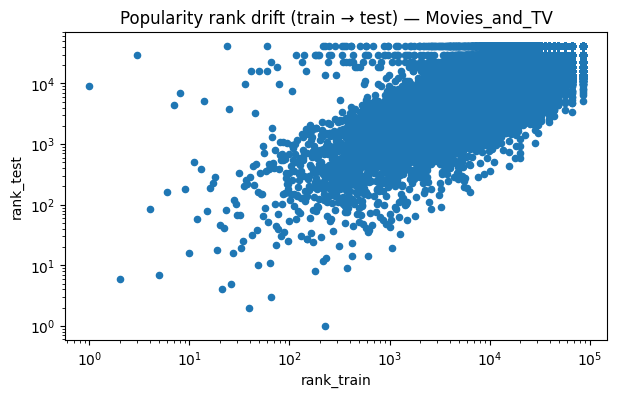

In [84]:
# Identify the domain that appears in val/test (expected: the target)
tgt_domains = list(set(val["domain"].unique()) | set(test["domain"].unique()))
print("Target domains from val/test:", tgt_domains)

if tgt_domains:
    tgt = tgt_domains[0]
    tr_tgt = train[train["domain"]==tgt]
    te_tgt = test[test["domain"]==tgt]

    pop_train = tr_tgt.groupby("iid").size().sort_values(ascending=False)
    pop_test  = te_tgt.groupby("iid").size().sort_values(ascending=False)

    common_items = pop_train.index.intersection(pop_test.index)
    if len(common_items):
        r_tr = pop_train.rank(ascending=False, method="min").reindex(common_items)
        r_te = pop_test.rank(ascending=False, method="min").reindex(common_items)
        ax = pd.DataFrame({"rank_train": r_tr, "rank_test": r_te}).plot(kind="scatter", x="rank_train", y="rank_test")
        ax.set_xscale("log"); ax.set_yscale("log")
        ax.set_title(f"Popularity rank drift (train → test) — {tgt}")
        plt.show()


In [96]:
import numpy as np
import pandas as pd

def _dens(rows, users, items):
    return rows / (users * items) if (users and items) else np.nan

def split_info_plus(df, name, movie_label=None, music_label=None):
    """
    Returns a Series with overall rows/users/items/density AND
    per-domain (movie/music) rows/users/items/density if available.
    """
    # overall
    users = df["uid"].nunique()
    items = df["iid"].nunique()
    rows  = len(df)
    out = {
        "rows": rows,
        "users": users,
        "items": items,
        "density": _dens(rows, users, items),
    }

    # per-domain if a domain column exists
    if "domain" in df.columns:
        # use provided labels if present; else guess from data
        if movie_label is None or music_label is None:
            dom_counts = df["domain"].value_counts()
            # try to infer by common substrings
            cand_movie = next((d for d in dom_counts.index if "mov" in str(d).lower()), None)
            cand_music = next((d for d in dom_counts.index if any(w in str(d).lower()
                                                                  for w in ["music","cds","vinyl","digital"])), None)
            movie_label = movie_label or cand_movie
            music_label = music_label or cand_music

        # movie slice
        if movie_label in set(df["domain"].astype(str)):
            dm = df[df["domain"] == movie_label]
            mu = dm["uid"].nunique()
            mi = dm["iid"].nunique()
            mr = len(dm)
            out.update({
                "movie_rows": mr,
                "movie_users": mu,
                "movie_items": mi,
                "movie_density": _dens(mr, mu, mi),
            })
        else:
            out.update({k: np.nan for k in ["movie_rows","movie_users","movie_items","movie_density"]})

        # music slice
        if music_label in set(df["domain"].astype(str)):
            ds = df[df["domain"] == music_label]
            su = ds["uid"].nunique()
            si = ds["iid"].nunique()
            sr = len(ds)
            out.update({
                "music_rows": sr,
                "music_users": su,
                "music_items": si,
                "music_density": _dens(sr, su, si),
            })
        else:
            out.update({k: np.nan for k in ["music_rows","music_users","music_items","music_density"]})
    else:
        # no domain column
        out.update({k: np.nan for k in [
            "movie_rows","movie_users","movie_items","movie_density",
            "music_rows","music_users","music_items","music_density"
        ]})

    return pd.Series(out, name=name)

# ---- build the summary table ----
summary = pd.concat([
    split_info_plus(train, "train", movie_label=movie_dom, music_label=music_dom),
    split_info_plus(val,   "val",   movie_label=movie_dom, music_label=music_dom),
    split_info_plus(test,  "test",  movie_label=movie_dom, music_label=music_dom),
], axis=1)

summary


,train,val,test
rows,4.328663e+06,319812.000000,507035.000000
users,5.070350e+05,319812.000000,507035.000000
items,4.432280e+05,57589.000000,74597.000000
density,1.926144e-05,0.000017,0.000013
movie_rows,1.931533e+06,319812.000000,507035.000000
movie_users,2.175140e+05,319812.000000,507035.000000
movie_items,1.209520e+05,57589.000000,74597.000000
movie_density,7.341788e-05,0.000017,0.000013
music_rows,2.397130e+06,NaN,NaN
music_users,5.070350e+05,NaN,NaN


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

ART = Path("artifacts/movies_from_music")  # change if needed
OUT = ART / "looker_exports"
OUT.mkdir(parents=True, exist_ok=True)

# ---- 0) Base events table (one row per interaction) ----
events = pd.concat([train, val, test], ignore_index=True)
events["date"] = pd.to_datetime(events["ts"], unit="s")
events["month"] = events["date"].dt.to_period("M").astype(str)
events = events[[
    "uid","iid","domain","item_cat","rating","rating_norm","ts","date","month","split"
]]
events.to_csv(OUT / "events.csv", index=False)

# ---- 1) Interactions per month (by domain) ----
monthly = (events
           .groupby(["domain","month"], as_index=False)
           .size()
           .rename(columns={"size":"interactions"}))
monthly.to_csv(OUT / "monthly_interactions.csv", index=False)

# ---- 2) Rating distributions (by domain & split) ----
ratings_summary = (events
                   .groupby(["domain","split"])
                   .agg(n=("rating","size"),
                        mean_rating=("rating","mean"),
                        p25=("rating", lambda x: np.percentile(x,25)),
                        p50=("rating","median"),
                        p75=("rating", lambda x: np.percentile(x,75)))
                   .reset_index())
ratings_summary.to_csv(OUT / "ratings_summary.csv", index=False)

# ---- 3) Item-level rating stats (for Top/Lowest rated) ----
# Add a "min_n" guard to avoid tiny-sample items on the dashboard
item_stats = (events
              .groupby(["domain","iid","item_cat"], as_index=False)
              .agg(n=("rating","size"),
                   users=("uid","nunique"),
                   mean_rating=("rating","mean"),
                   median_rating=("rating","median"),
                   std_rating=("rating","std")))
item_stats.to_csv(OUT / "item_rating_stats.csv", index=False)

# ---- 4) Category stats (per domain) ----
cat_stats = (events
             .groupby(["domain","item_cat"], as_index=False)
             .agg(n=("rating","size"),
                  users=("uid","nunique"),
                  mean_rating=("rating","mean")))
cat_stats.to_csv(OUT / "category_stats.csv", index=False)

# ---- 5) Bridge-user co-occurrence for heatmaps (music→movie) ----
# Build user×cat (binary) matrices
def user_cat_bin(df):
    dfg = (df.assign(cat=df["item_cat"].fillna("unknown").astype(str))
             .groupby(["uid","cat"]).size().unstack(fill_value=0))
    return (dfg > 0).astype(int)

music_df = events[events["domain"].str.contains("Music", case=False, na=False)].copy()
movie_df = events[events["domain"].str.contains("Movie", case=False, na=False)].copy()

M = user_cat_bin(music_df)
V = user_cat_bin(movie_df)

U = M.index.intersection(V.index)
M, V = M.loc[U], V.loc[U]
N = float(len(U))


# co-occurrence counts
C = M.T.dot(V)  # rows = music_cat, cols = movie_cat
C.index.name = "music_cat"
C.columns.name = "movie_cat"

cooc = (
    C.stack()                                   # long form
     .rename("cooc_users")                      # the value column
     .reset_index()                             # columns: music_cat, movie_cat, cooc_users
)

mus_users = M.sum(axis=0)      # users per music category
mov_users = V.sum(axis=0)      # users per movie category

cooc["mus_users"] = cooc["music_cat"].map(mus_users)
cooc["mov_users"] = cooc["movie_cat"].map(mov_users)
cooc["N_bridge"]  = int(N)
cooc["p_movie_given_music"] = cooc["cooc_users"] / cooc["mus_users"].replace(0, np.nan)
cooc["lift"] = (cooc["cooc_users"] * N) / (cooc["mus_users"] * cooc["mov_users"]).replace(0, np.nan)

cooc.to_csv(OUT / "music_to_movie_cooccurrence.csv", index=False)

# ---- 6) Base movie rates among bridge users ----
base_movie = (V.sum(axis=0) / N).rename("p_movie").reset_index().rename(columns={"cat":"movie_cat"})
base_movie.to_csv(OUT / "base_movie_rates.csv", index=False)

# ---- 7) Cold-start scorecards (vs train) ----
train_users = set(train["uid"]); train_items = set(train["iid"])
val_user_unseen  = ( ~val["uid"].isin(train_users) ).mean()
test_user_unseen = ( ~test["uid"].isin(train_users) ).mean()
val_item_unseen  = ( ~val["iid"].isin(train_items) ).mean()
test_item_unseen = ( ~test["iid"].isin(train_items) ).mean()
cold = pd.DataFrame([{
    "val_users_not_in_train_pct":  val_user_unseen,
    "test_users_not_in_train_pct": test_user_unseen,
    "val_items_not_in_train_pct":  val_item_unseen,
    "test_items_not_in_train_pct": test_item_unseen,
    "bridge_users": int(N)
}])
cold.to_csv(OUT / "cold_start_overview.csv", index=False)

print("Exported CSVs to:", OUT)
